In [27]:
T = [[[],[]],[[],[]],[[],[]]]
with open("/home/iven/Documents/mipt/BbI4MaT/tests/test10000") as f:
    for i in f.readlines():
        tmp = i.split()
        if tmp[0]=="Ugaus":
            T[0][0].append(int(tmp[1]))
            T[0][1].append(float(tmp[2]))
        if tmp[0]=="Gaus":
            T[1][0].append(int(tmp[1]))
            T[1][1].append(float(tmp[2]))
        if tmp[0]=="LU":
            T[2][0].append(int(tmp[1]))
            T[2][1].append(float(tmp[2]))
Told = [[[],[]],[[],[]],[[],[]]]
with open("/home/iven/Documents/mipt/BbI4MaT/tests/test10000_Last") as f:
    for i in f.readlines():
        tmp = i.split()
        if tmp[0]=="Ugaus":
            Told[0][0].append(int(tmp[1]))
            Told[0][1].append(float(tmp[2]))
        if tmp[0]=="Gaus":
            Told[1][0].append(int(tmp[1]))
            Told[1][1].append(float(tmp[2]))
        if tmp[0]=="LU":
            Told[2][0].append(int(tmp[1]))
            Told[2][1].append(float(tmp[2]))

In [28]:

import matplotlib.pyplot as plt

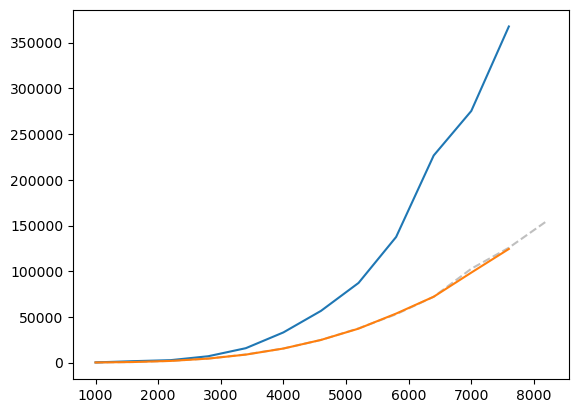

In [29]:
plt.plot(T[0][0], T[0][1], '--', color='gray', alpha=0.5)
plt.plot(T[1][0], T[2][1])
plt.plot(T[2][0], T[1][1])

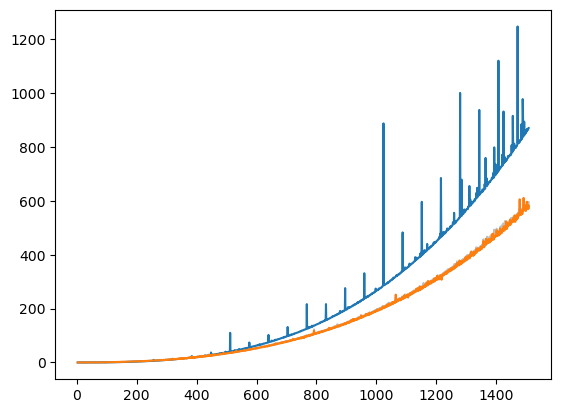

In [31]:
plt.plot(Told[0][0], Told[0][1], color='gray', alpha=0.5)
plt.plot(Told[1][0], Told[2][1])
plt.plot(Told[2][0], Told[1][1])